## Notes

In [297]:
# Environment Setup
#install.packages("GGally") 
#install.packages("gridExtra")
library(tidyverse)
library(tidymodels)
library(readxl)
library(GGally)
library(gridExtra)

options(repr.plot.width = 10, repr.plot.height = 8)

# Credit Card Default Prediction
___

## Introduction
___

#### **Background** ####
Credit Card is an essential part of our daily lives today. Per Statista there were 76M credit cards in circulation within Canada implaying 2 per every Canadian. In addition to the impact it has on everyday citizens, credit card is booming and loan securitization is a huge business for banks and asset managers. As such, a large credit card default at a macro level could lead to systemic failures of banks and the broader capital markets similar to the one observed in GFC.

#### **Thesis** ####
Using the data and the techniques learned in class, we would like to answer the question: **can we predict the default status of a credit card client?**

#### **Data** ####
The data is from an unnamed debit and credit card issuing bank in Taiwan. The data consists of information about 30,000 customers as at October 2005, of which 23,364 (78%) have not defaulted while 6,636 (22%) have defaulted. The default status is represented as binary variable (1 = Yes, 0 = No). Variables available to be used as direct inputs are as below:
* **X1**: Amount of Credit Given (NT$)
* **X2**: Sex (1 = Male, 2 = Female)
* **X3**: Education (1 = Graduate School, 2 = University, 3 = High School, 4 = Others)
* **X4**: Marital Status (1 = Married, 2 = Single, 3 = Others)
* **X5**: Age (# of Years)
* **X6-X11**: Repayment Status (-1 = Clear, 1 = Payment Delay of 1 Month, 2 = Payment Delay of 2 Months, ..., 8 = Payment Delay of 8 Months, 9 = Payment Delay of 9 Months or greater)
    * **X6**  = Repayment status in 2005-09
    * **X7**  = Repayment status in 2005-08
    * **X8**  = Repayment status in 2005-07
    * **X9**  = Repayment status in 2005-06
    * **X10** = Repayment status in 2005-05
    * **X11** = Repayment status in 2005-04
* **X12-X17**: Amount of Bill Statement (NT$)
    * **X12** = Amount of Bill Statement in 2005-09
    * **X13** = Amount of Bill Statement in 2005-08
    * **X14** = Amount of Bill Statement in 2005-07
    * **X15** = Amount of Bill Statement in 2005-06
    * **X16** = Amount of Bill Statement in 2005-05
    * **X17** = Amount of Bill Statement in 2005-04
* **X18-X23**: Amount of Previous Payment (NT$)
    * **X18** = Amount Paid in 2005-09
    * **X19** = Amount Paid in 2005-08
    * **X21** = Amount Paid in 2005-06
    * **X20** = Amount Paid in 2005-07
    * **X21** = Amount Paid in 2005-05
    * **X23** = Amount Paid in 2005-04

Source of Data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

## Preliminary Exploratory Data Analysis
___

* Demonstrate that the dataset can be read from the web into R 
* Clean and wrangle your data into a tidy format
* Using only **training data**, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
* Using only **training data**, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.


### Data Loading, Cleaning, Splitting ###
____

In [260]:
columns = c('id', 'credit_limit', 'sex', 'education', 'marital_status', 'age',
            'status_09', 'status_08', 'status_07', 'status_06', 'status_05', 'status_04',
            'balance_09', 'balance_08', 'balance_07', 'balance_06', 'balance_05', 'balance_04',
            'payment_09', 'payment_08', 'payment_07', 'payment_06', 'payment_05', 'payment_04',
            'y')
            
credit_card_data <- read_excel('data/default of credit card clients.xls',sheet='Data',skip=2,col_names=columns) |>
    select(-id)

credit_card_data <- credit_card_data |>
    mutate(status_09 = status_09+1,
        status_08 = status_08+1,
        status_07 = status_07+1,
        status_06 = status_06+1,
        status_05 = status_05+1,
        status_04 = status_04+1) |>
    filter(marital_status %in% c(1,2,3)) |>
    filter(sex %in% c(1,2)) |>
    filter(education %in% c(1,2,3,4))

head(credit_card_data)

credit_limit,sex,education,marital_status,age,status_09,status_08,status_07,status_06,status_05,⋯,balance_06,balance_05,balance_04,payment_09,payment_08,payment_07,payment_06,payment_05,payment_04,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20000,2,2,1,24,3,3,0,0,-1,⋯,0,0,0,0,689,0,0,0,0,1
120000,2,2,2,26,0,3,1,1,1,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,2,2,2,34,1,1,1,1,1,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,2,2,1,37,1,1,1,1,1,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,1,2,1,57,0,1,0,1,1,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,1,1,2,37,1,1,1,1,1,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


In [261]:
set.seed(154)
credit_card_split <- credit_card_data |> initial_split(prop=0.75, strata = y)
credit_card_train <- training(credit_card_split)
credit_card_test <- testing(credit_card_split)

### Visualization ###
____

### Test for NA Data ###

In [262]:
na_data_count <- sapply(credit_card_train,function(x) sum(is.na(x))) |>
    t() |>
    as_tibble()
    
na_data_count

credit_limit,sex,education,marital_status,age,status_09,status_08,status_07,status_06,status_05,⋯,balance_06,balance_05,balance_04,payment_09,payment_08,payment_07,payment_06,payment_05,payment_04,y
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### Summary of Categorical Columns ###

In [263]:
credit_card_train |>
    group_by(y) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

y,count,average_age,average_credit_limit,average_balance_09
<dbl>,<int>,<dbl>,<dbl>,<dbl>
0,17247,35.39015,178142.6,52382.82
1,4953,35.64527,131515.8,47883.55


In [264]:
credit_card_train |>
    group_by(sex) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

sex,count,average_age,average_credit_limit,average_balance_09
<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,8808,36.48899,164417.3,54876.21
2,13392,34.76180,169925.0,49078.85


In [265]:
credit_card_train |>
    group_by(education) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

education,count,average_age,average_credit_limit,average_balance_09
<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,7885,34.20812,213247.9,49532.46
2,10604,34.72105,147226.1,53711.06
3,3624,40.30298,127339.3,48303.86
4,87,33.95402,226436.8,62585.16


In [266]:
credit_card_train |>
    group_by(marital_status) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

marital_status,count,average_age,average_credit_limit,average_balance_09
<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,10119,39.96680,183160.98,53308.12
2,11834,31.42488,156069.60,49915.76
3,247,42.99190,95101.21,42452.24


In [267]:
credit_card_train |>
    group_by(status_09) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

status_09,count,average_age,average_credit_limit,average_balance_09
<dbl>,<int>,<dbl>,<dbl>,<dbl>
-1,2034,36.98722,250255.65,8443.311
0,4147,36.19918,208314.44,10451.482
1,10980,34.91867,154285.76,78091.323
2,2752,35.34121,149138.81,27651.698
3,1947,35.36466,111543.91,65841.426
4,233,35.42918,85021.46,39023.399
5,57,35.24561,78771.93,67193.930
6,18,35.11111,84444.44,100966.444
7,9,36.11111,84444.44,85770.778


### Summary of Numeric Columns ###

In [268]:
numeric_cols_train <- credit_card_train |>
    select(-sex, -education, -marital_status, -status_09, -status_08, -status_07, -status_06, -status_05, -status_04)

min_0 <- apply(filter(numeric_cols_train, y == 0), 2, min, na.rm = TRUE)
average_0 <- apply(filter(numeric_cols_train, y == 0), 2, mean, na.rm = TRUE)
median_0 <- apply(filter(numeric_cols_train, y == 0), 2, median, na.rm = TRUE)
max_0 <- apply(filter(numeric_cols_train, y == 0), 2, max, na.rm = TRUE)

min_1 <- apply(filter(numeric_cols_train, y == 1), 2, min, na.rm = TRUE)
average_1 <- apply(filter(numeric_cols_train, y == 1), 2, mean, na.rm = TRUE)
median_1 <- apply(filter(numeric_cols_train, y == 1), 2, median, na.rm = TRUE)
max_1 <- apply(filter(numeric_cols_train, y == 1), 2, max, na.rm = TRUE)

In [269]:
numeric_cols_summary <- rbind(min_0, average_0, median_0, max_0, min_1, average_1, median_1, max_1) |>
    as_tibble() |>
    mutate(info = c('Min','Mean','Median','Max','Min','Mean','Median','Max')) |>
    relocate(y,.before=credit_limit) |>
    relocate(info,.before=credit_limit)

numeric_cols_summary

y,info,credit_limit,age,balance_09,balance_08,balance_07,balance_06,balance_05,balance_04,payment_09,payment_08,payment_07,payment_06,payment_05,payment_04
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,Min,10000.0,21.00000,-15308.00,-67526.00,-157264.00,-170000.00,-81334.00,-209051.00,0.000,0.000,0.000,0.000,0.000,0.000
0,Mean,178142.6,35.39015,52382.82,50110.76,47903.33,43961.13,40994.48,39694.07,6353.887,6655.716,5732.676,5285.201,5255.274,5690.534
0,Median,150000.0,34.00000,23900.00,22441.00,20694.00,19262.00,18258.00,17159.00,2500.000,2253.000,2000.000,1786.000,1829.000,1740.000
0,Max,1000000.0,79.00000,964511.00,983931.00,1664089.00,891586.00,927171.00,961664.00,873552.000,1684259.000,896040.000,621000.000,426529.000,528666.000
1,Min,10000.0,21.00000,-6029.00,-9119.00,-61506.00,-65167.00,-53007.00,-339603.00,0.000,0.000,0.000,0.000,0.000,0.000
1,Mean,131515.8,35.64527,47883.55,46779.31,44618.47,41600.41,39327.82,38206.65,3447.671,3405.968,3284.918,3089.582,3345.432,3568.310
1,Median,90000.0,34.00000,20214.00,20358.00,19783.00,19068.00,18283.00,17932.00,1633.000,1514.000,1200.000,1000.000,1000.000,1000.000
1,Max,740000.0,73.00000,613860.00,581775.00,572677.00,541019.00,547880.00,498316.00,300000.000,358689.000,234456.000,432130.000,332000.000,345293.000


### Visualization ###
____

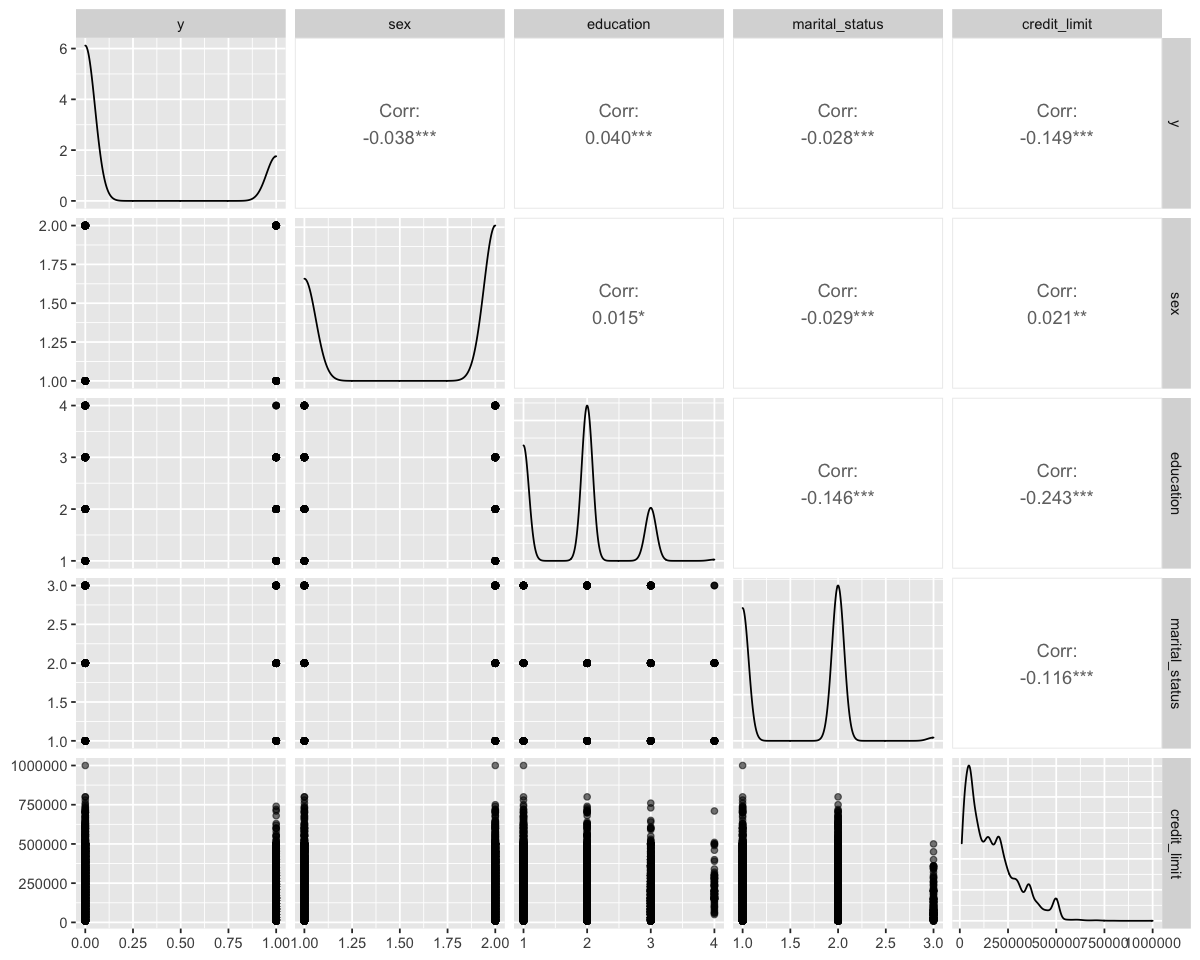

In [270]:
options(repr.plot.width = 10, repr.plot.height = 8) 

credit_card_train |> 
    select(y, sex, education, marital_status,credit_limit) |>
    ggpairs(ggplot2::aes(alpha = 0.3))

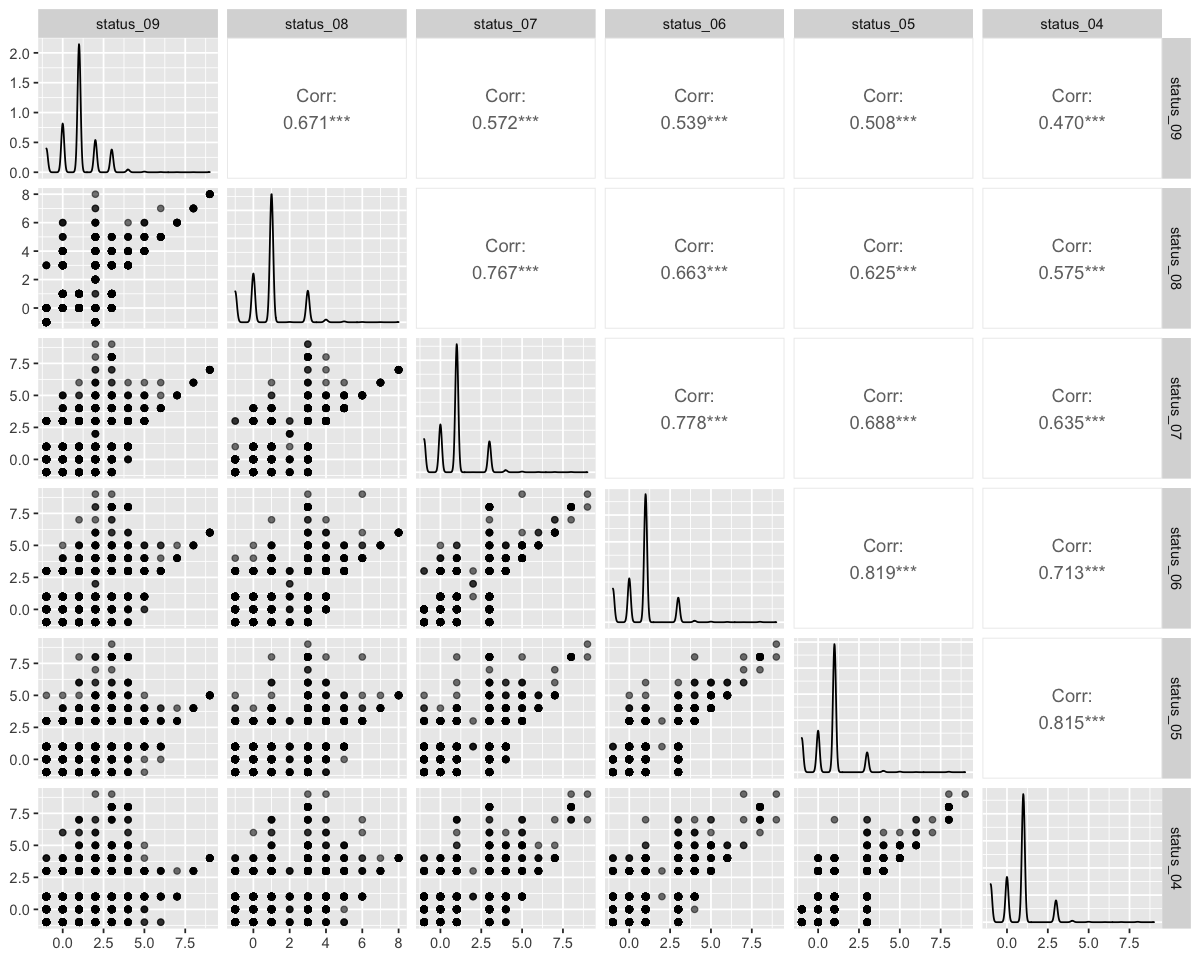

In [271]:
options(repr.plot.width = 10, repr.plot.height = 8) 

credit_card_train |> 
    select(status_09,status_08,status_07,status_06,status_05,status_04) |>
    ggpairs(ggplot2::aes(alpha = 0.3))

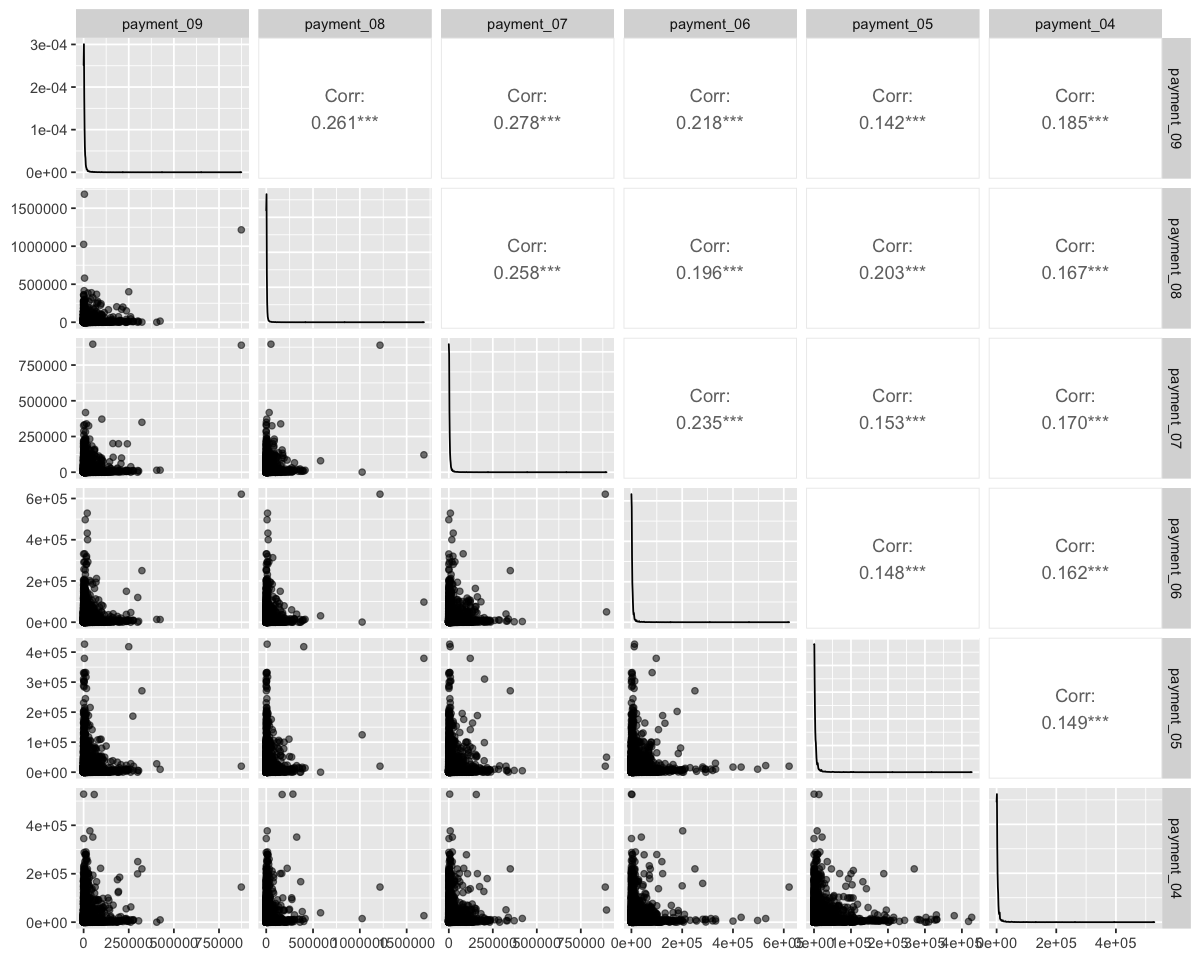

In [272]:
options(repr.plot.width = 10, repr.plot.height = 8) 

credit_card_train |> 
    select(payment_09,payment_08,payment_07,payment_06,payment_05,payment_04) |>
    ggpairs(ggplot2::aes(alpha = 0.3))

`summarise()` has grouped output by 'sex', 'education'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'sex', 'marital_status'. You can override
using the `.groups` argument.


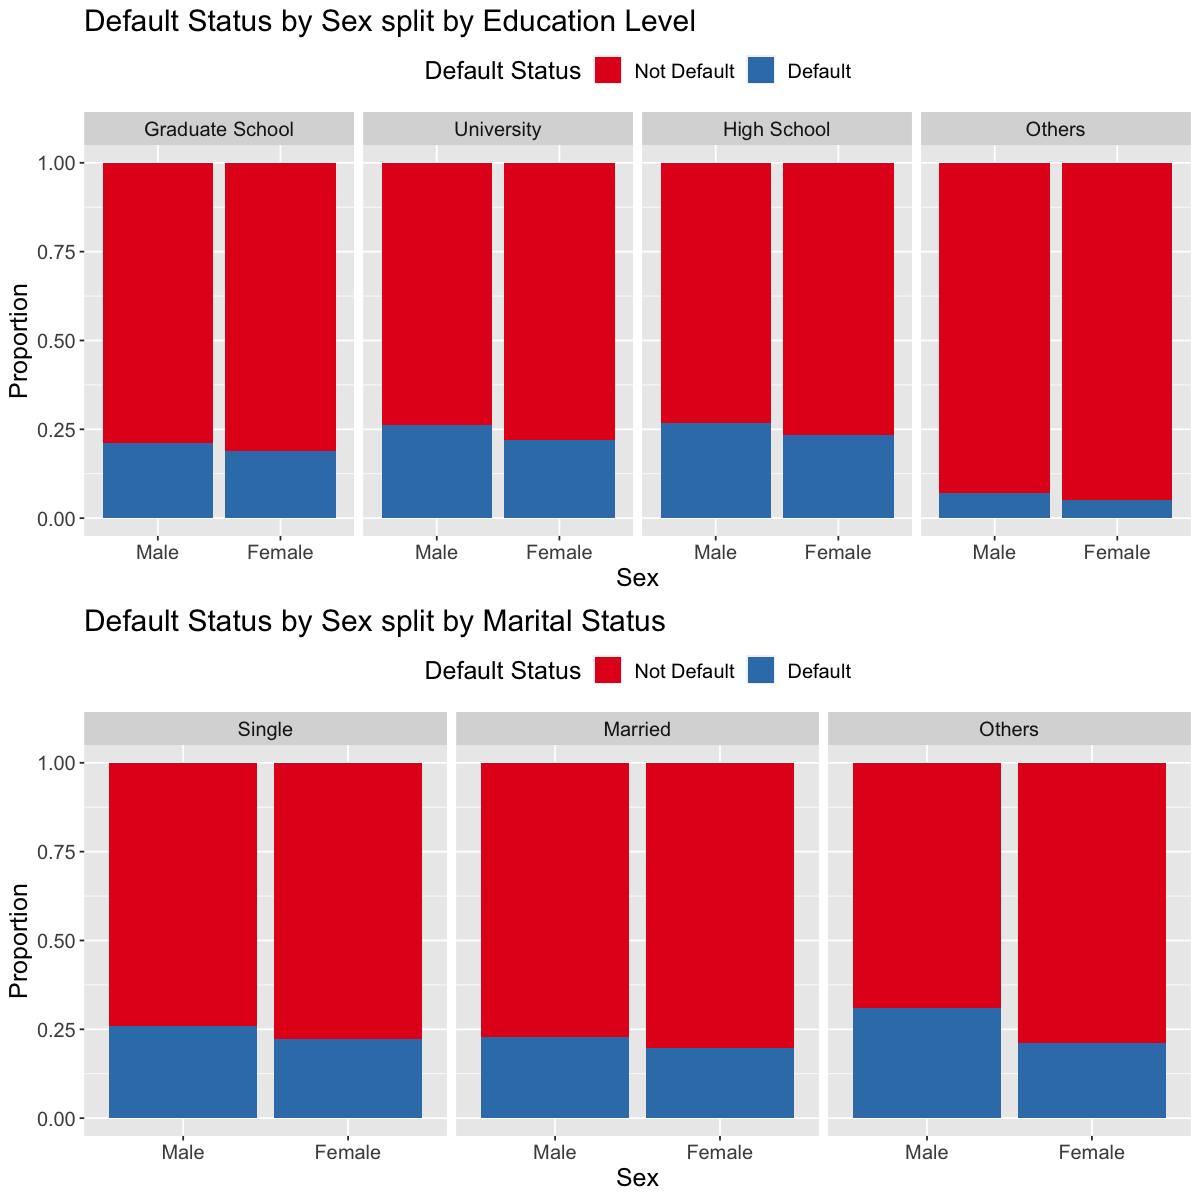

In [334]:
options(repr.plot.width = 10, repr.plot.height = 10) 

default_vs_sex_edu <- credit_card_train |>
    group_by(sex, education, y) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(sex),y=n,fill=as_factor(y))) +
    geom_bar(stat="identity",position="fill") +
    facet_wrap(~ education,ncol=4, labeller = labeller(
        education = c("1" = "Graduate School", "2" = "University", "3" = "High School", "4" = "Others"))) +
    scale_x_discrete(labels = c("1"="Male","2"="Female")) +
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    labs(x = "Sex"
        ,y = "Proportion"
        ,fill = "Default Status"
        ,title= "Default Status by Sex split by Education Level") +
    theme(text = element_text(size=15),legend.position = "top")

default_vs_sex_mar <- credit_card_train |>
    group_by(sex, marital_status, y) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(sex),y=n,fill=as_factor(y))) +
    geom_bar(stat="identity",position="fill") +
    facet_wrap(~ marital_status,ncol=4, labeller = labeller(
        marital_status = c("1" = "Single", "2" = "Married", "3" = "Others"))) +
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    scale_x_discrete(labels = c("1"="Male","2"="Female")) +
    labs(x = "Sex"
        ,y = "Proportion"
        ,fill = "Default Status"
        ,title= "Default Status by Sex split by Marital Status") +
    theme(text = element_text(size=15),legend.position = "top")

grid.arrange(default_vs_sex_edu,default_vs_sex_mar)

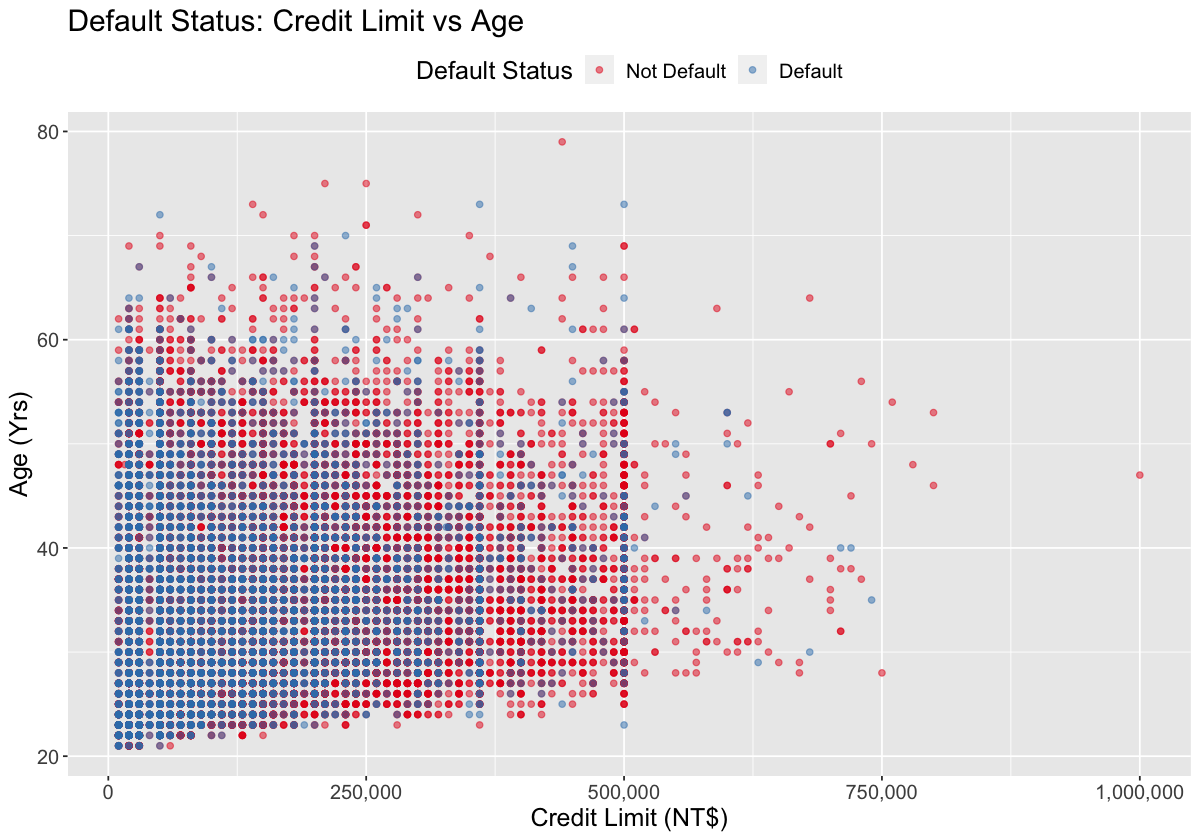

In [336]:
options(repr.plot.width = 10, repr.plot.height = 7) 

age_vs_credit_limit <- credit_card_train |>
    ggplot(aes(x=credit_limit,y=age, color=as_factor(y))) +
    geom_point(alpha=0.5) +
    scale_color_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    scale_x_continuous(labels = comma) +
    labs(x="Credit Limit (NT$)"
        , y="Age (Yrs)"
        , color = "Default Status"
        , title= "Default Status: Credit Limit vs Age") +
    theme(text = element_text(size=15),legend.position = "top")

age_vs_credit_limit

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



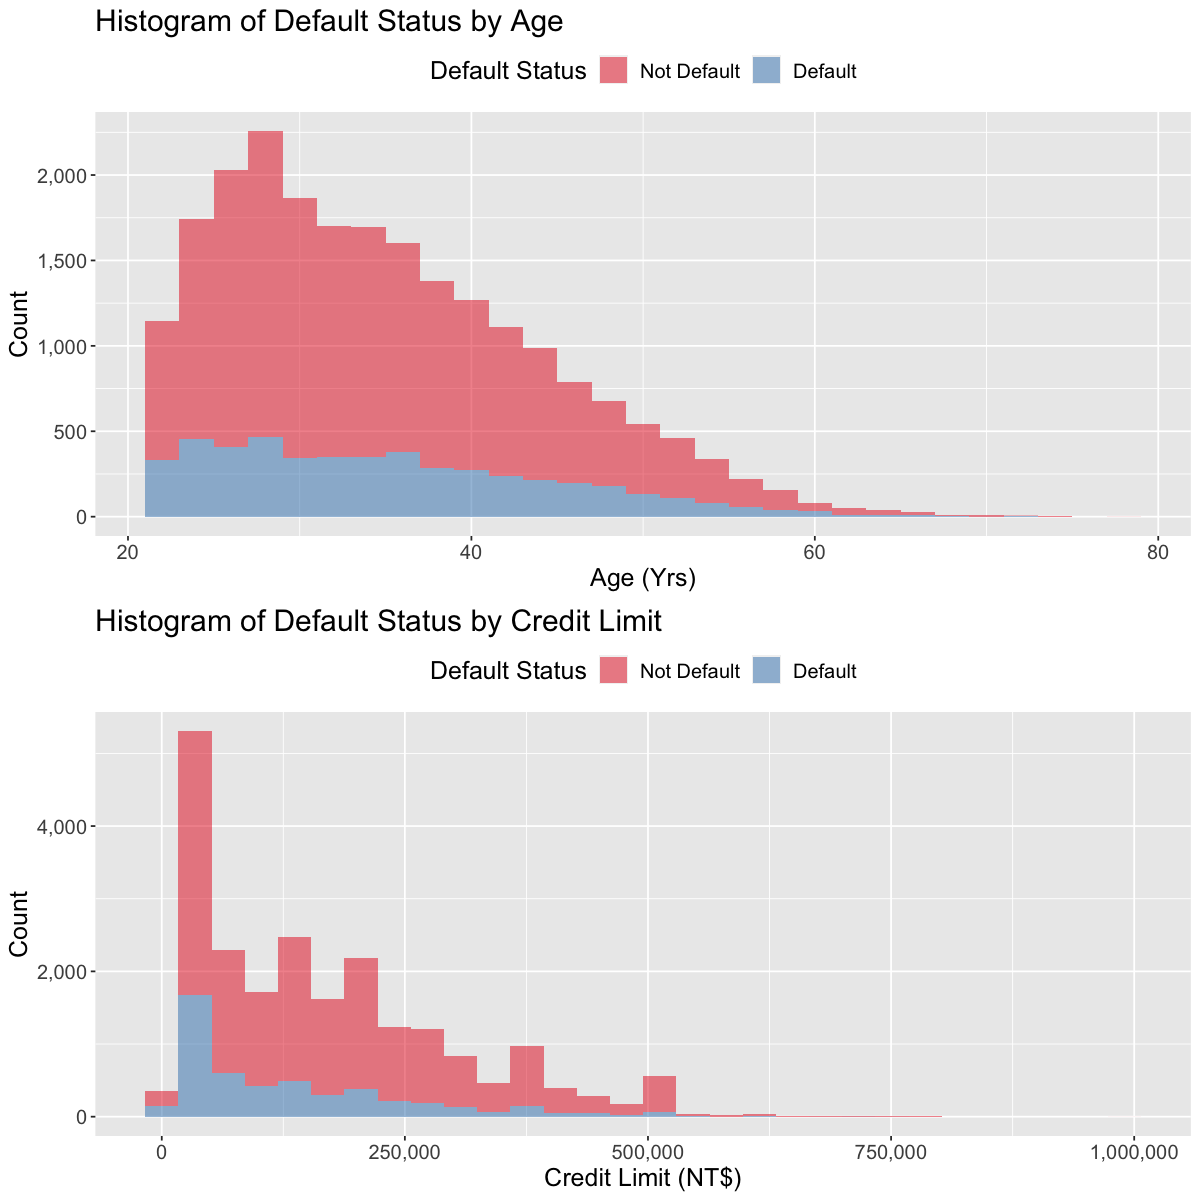

In [337]:
options(repr.plot.width = 10, repr.plot.height = 10) 

density_plot_age <- credit_card_train |>
    ggplot()+
    geom_histogram(aes(x=age, fill = as_factor(y)),alpha=0.5)+
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1")+
    scale_x_continuous(labels = comma)+
    scale_y_continuous(labels = comma)+
    labs(x="Age (Yrs)"
        , y="Count"
        , fill="Default Status"
        , title="Histogram of Default Status by Age")+
    theme(text = element_text(size=15),legend.position = "top")


density_plot_credit_limit <- credit_card_train |>
    ggplot()+
    geom_histogram(aes(x=credit_limit, fill = as_factor(y)),alpha=0.5)+
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1")+
    scale_x_continuous(labels = comma)+
    scale_y_continuous(labels = comma)+
    labs(x="Credit Limit (NT$)"
        , y="Count"
        , fill="Default Status"
        , title="Histogram of Default Status by Credit Limit")+
    theme(text = element_text(size=15),legend.position = "top")

grid.arrange(density_plot_age,density_plot_credit_limit)

## Methods
___

* As a first step, we will look to enhance the available the input variables through feature engineering.
    * For instance, payment history should be reviewed in proportion to each person's outstanding credit balance. This could take the form of:
        ```r
            ... <- ... |> 
                mutate(debt_paid_pct_n = payment_n / balance_n)
        ```
    * In addition, we can explore ways to contextualize the momentum of such history of payment. A reasonable place to start there may be asking - does increasing pace of payment month over month imply lower likelihood of defaulting? Such variable could be proxied as such:
        ```r
            ... <- ... |> 
                mutate(momentum_n = payment_n / payment_m -1)
        ```
    * Another factor could be the level of financial stress as proxied by the outstanding debt over the available balance. This could take the form of:
        ```r
            ... <- ... |>
                mutate(pct_credit_used_n = balance_n / credit_limit)
        ```

* After creating columns that are combination of the given data, we will select variables that most likely explains a person's default status next month. For instance, payment amount from 5 months ago is less likely to have significant explanatory power over that of last months' payment. Based on first impression, we will likely not use the payment status, outstanding balance, and payment history as a direct input. What would be more interesting is the derivative factors such as the ones mentioned above.

* After training the model and producing the predicted output, we will visualize the results in several ways. Below are just examples:
    1. Direct comparison between $Y$ and $\hat{Y}$ using scatterplot
    2. Comparison by demographic profile to see if the model is able to better predict within certain class

## Expected Outcomes and Significance
___

**We expect to find varying degree of relationship between default status and direct categorical variables.**
1. Positive relationship between default status vs education. 
2. No relationship between default status vs age, sex, and marital status.

**The findings could have broad positive impact. Specifically, it could:**
1. Create a less risky credit environment for both banks and credit card users
2. Provide better rates for less-risky credit card users
3. Develop educational programs for people at higher risk to minimize chnace of systemic credit defaults.

**This could lead us to future questions like:**
1. What role does employment play in the default status of a credit card?